


<font size='10' color = 'E3A440'>**Mégadonnées et techniques avancées démystifiées**</font>
=======
<font color = 'E3A440'>*Nouvelles méthodes d’analyse et leur implication quant à la gestion des mégadonnées en SSH (partie 2)*</font>
=============


Cet atelier s’inscrit dans le cadre de la formation [Mégadonnées et techniques avancées démystifiées](https://www.4point0.ca/2022/08/22/formation-megadonnees-demystifiees/) (séance 6).

Les sciences humaines et sociales sont souvent confrontées à l’analyse de données non structurées, comme le texte. Après avoir préparé les données, plusieurs techniques d’analyse venant de l’apprentissage automatique peuvent être utilisées. Pendant cet atelier, les participants seront initiés au prétraitement des données textuelles et aux méthodes supervisées et non supervisées à des buts d’analyse avec Python.

Note : Cet atelier se poursuit lors d’une 2e séance le **10 novembre 2022**. Les deux séances ne peuvent pas être considerées exaustives du domaine.

Structure de l'atelier :
1. Partie 1 : à revoir

### Auteurs: 
- Bruno Agard <bruno.agard@polymtl.ca>
- Davide Pulizzotto <davide.pulizzotto@polymtl.ca>

Département de Mathématiques et de génie industriel

École Polytechnique de Montréal

# <font color = 'E3A440'>0. Préparation de l'environnement </font>

In [1]:
# Downloading of data from the GitHub project
#!rm -rf Data_techniques_demystified_webinars/
!rm -rf Donnees_demystifiees_seance_6/
#!git clone https://github.com/4point0-ChairInnovation-Polymtl/Data_techniques_demystified_webinars
!git clone https://github.com/puli83/Donnees_demystifiees_seance_6

Cloning into 'Donnees_demystifiees_seance_6'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 113 (delta 9), reused 0 (delta 0), pack-reused 94
Receiving objects: 100% (113/113), 45.73 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
# Import modules
import os
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

# <font color = 'E3A440'>1. Prétraitement du corpus (rappels)</font>

Le prétraitement d'un corpus de textes peut nécessiter la mise en place de plusieurs étapes dont : le découpage des phrases, des mots, le nettoyage, le filtrage...

In [236]:
text = """At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.
          The following morning, at nine, Arthur felt better.
          A dog runs in the street.
          A little boy runs in the street.
          Arthur is my dog, he sleeps every morning."""


In [237]:
# extraction des phrases
sentences = nltk.sent_tokenize(text)
print(sentences)

["At eight o'clock, on Thursday morning, the great Arthur didn't feel VERY good.", 'The following morning, at nine, Arthur felt better.', 'A dog runs in the street.', 'A little boy runs in the street.', 'Arthur is my dog, he sleeps every morning.']


In [238]:
# Fonction de nettoyage de la session précédente
def CleaningText(text_as_string, language = 'english', reduce = '', list_pos_to_keep = [], Stopwords_to_add = []):
    from nltk.corpus import stopwords

    words = nltk.word_tokenize(text_as_string)
    words_pos = nltk.pos_tag(words, tagset='universal')
    words_pos = [(w, pos) for w, pos in words_pos if w.isalnum()]
    words_pos = [(w.lower(), pos) for w, pos in words_pos]
    
    if reduce == 'stem': 
        from nltk.stem.porter import PorterStemmer
        reduced_words_pos = [(PorterStemmer().stem(w), pos) for w, pos in words_pos]
        
    elif reduce == 'lemma':
        from nltk.stem.wordnet import WordNetLemmatizer
        reduced_words_pos = [(WordNetLemmatizer().lemmatize(w), pos) for w, pos in words_pos]
    else:
        import warnings
        reduced_words_pos = words_pos
        warnings.warn("Warning : any reduction was made on words! Please, use \"reduce\" argument to chosse between 'stem' or  'lemma'")
    if list_pos_to_keep:
        reduced_words_pos = [(w, pos) for w, pos in reduced_words_pos if pos in list_pos_to_keep]
    else:
        import warnings
        warnings.warn("Warning : any POS filtering was made. Please, use \"list_pos_to_keep\" to create a list of POS tag to keep.")
    
    list_stopwords = stopwords.words(language) + Stopwords_to_add
    reduced_words_pos = [(w, pos) for w, pos in reduced_words_pos if w not in list_stopwords and len(w) > 1 ]
    return reduced_words_pos



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import unique
from numpy import where

def draw(X,yhat):
    # retrieve unique clusters
    clusters = unique(yhat)

    #plt.figure(figsize=(10, 10))
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])

    plt.title("Clusters")
    # show the plot
    plt.show()    

In [239]:
# nettoyage des phrases, sélection de pos-tag
cleaned_sentences = [CleaningText(sent, reduce = 'lemma', list_pos_to_keep = ['NOUN','ADJ','VERB']) for sent in sentences]
print(cleaned_sentences)

[[('thursday', 'NOUN'), ('morning', 'NOUN'), ('great', 'ADJ'), ('arthur', 'NOUN'), ('feel', 'VERB'), ('good', 'ADJ')], [('following', 'ADJ'), ('morning', 'NOUN'), ('arthur', 'NOUN'), ('felt', 'VERB')], [('dog', 'NOUN'), ('run', 'VERB'), ('street', 'NOUN')], [('little', 'ADJ'), ('boy', 'NOUN'), ('run', 'NOUN'), ('street', 'NOUN')], [('arthur', 'NOUN'), ('dog', 'NOUN'), ('sleep', 'VERB'), ('morning', 'NOUN')]]


# <font color = 'E3A440'>2. Vectorisation (rappels)</font>

Le contenu des textes est représenté sous forme matricielle.

$$X = \begin{bmatrix} 
x_{1,1} & x_{1,2} & \ldots & x_{1,w} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
x_{n,1} & x_{1,2} & \ldots & x_{n,w} \\
\end{bmatrix}
$$ 

Avec :

- $x_{i,j}$ peut représenter la présence du mot "j" dans le texte $i$,
- $x_{i,j}$ peut mesurer le nombre d'occurences du mot $j$ dans le texte $i$,
- $x_{i,j}$ peut représenter l'**importance** du mot $j$ dans le texte $i$, dans ce cas on utilisera par exemple la métrique tf-idf :
 $$\text{tf-idf}_{i,j}=\text{tf}_{i,j}.log\left(\frac{n}{n_i}\right)$$
 - $\text{tf}_{i,j}$ est la fréquence du terme $i$ dans le document $j$,
 - $n$ nombre total de documents dans l’ensemble de textes à étudier,
 - $n_i$ nombre de documents dans l’ensemble de textes qui contiennent le terme $i$.


In [243]:
# Initialisation de l'objet
def identity_tokenizer(text):
    return text

# Transforming the word in frequencies
vectorized = CountVectorizer(lowercase = False, # Convert all characters to lowercase before tokenizing
                             min_df = 1, # Ignore terms that have a document frequency strictly lower than the given threshold 
                             max_df = 10, # Ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
                             stop_words = stopwords.words('english'), # Remove the list of words provided
                             ngram_range = (1, 1), # Get the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted
                             tokenizer=identity_tokenizer) # Override the string tokenization step while preserving the preprocessing and n-grams generation steps

Utilisation du "vectorizer" avec une liste de listes de mots (et non une liste de tuples de mots-pos).

In [245]:
# Application du vectorizer
freq_term_DTM = vectorized.fit_transform([[w for w, pos in sent] for sent in cleaned_sentences])
#print(freq_term_DTM)

freq_Matrix=pd.DataFrame(freq_term_DTM.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(freq_Matrix)

   arthur  boy  dog  feel  felt  following  good  great  little  morning  run  \
0       1    0    0     1     0          0     1      1       0        1    0   
1       1    0    0     0     1          1     0      0       0        1    0   
2       0    0    1     0     0          0     0      0       0        0    1   
3       0    1    0     0     0          0     0      0       1        0    1   
4       1    0    1     0     0          0     0      0       0        1    0   

   sleep  street  thursday  
0      0       0         1  
1      0       0         0  
2      0       1         0  
3      0       1         0  
4      1       0         0  


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


Les valeurs des poids Tf-Idf sont stockés dans la variable `tfidf_DTM`. 

In [246]:
# Calculate the tfidf matrix
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM = tfidf.fit_transform(freq_term_DTM)
#print(tfidf_DTM)

tfidf_Matrix=pd.DataFrame(tfidf_DTM.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(tfidf_Matrix)

     arthur       boy       dog      feel      felt  following      good  \
0  0.125428  0.000000  0.000000  0.187286  0.000000   0.000000  0.187286   
1  0.200547  0.000000  0.000000  0.000000  0.299453   0.299453  0.000000   
2  0.000000  0.000000  0.333333  0.000000  0.000000   0.000000  0.000000   
3  0.000000  0.276733  0.000000  0.000000  0.000000   0.000000  0.000000   
4  0.212863  0.000000  0.256433  0.000000  0.000000   0.000000  0.000000   

      great    little   morning       run     sleep    street  thursday  
0  0.187286  0.000000  0.125428  0.000000  0.000000  0.000000  0.187286  
1  0.000000  0.000000  0.200547  0.000000  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  0.333333  0.000000  0.333333  0.000000  
3  0.000000  0.276733  0.000000  0.223267  0.000000  0.223267  0.000000  
4  0.000000  0.000000  0.212863  0.000000  0.317842  0.000000  0.000000  


# <font color = 'E3A440'>3. Méthodes non supervisées</font>

## <font color = 'E3A440'>3.0. Segmentation </font>


Le but de la segmentation est de diviser un ensemble de données en sous ensembles plus petits qui partagent certaines caractéristiques.

On veut à la fois que les éléments au sein d'un même sous groupe sous le plus similaires possibles, et que les sous ensembles soient le plus dissimilaires possibles entre eux.

Une grande majorité des méthodes de segmentation est alors basée sur des métriques de distance.




## <font color = 'E3A440'>3.1. Métriques de similarités, distances entre points </font>


Il existe de nombreuses métriques pour évaluer la similarité/distance entre deux points :


### Distance Euclidienne

$$d(x_1,x_2) = \sqrt{\sum_i^n\left(x_{1,i},x_{2,i}\right)^2}$$


### Distances de Hamming

En nombre de coordonnées différentes

$$d_1(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    0,\ if\ x_{1,i} = x_{2,i}\\
    Sinon\ 1\\
    \end{cases}
\end{split}


En nombre de coordonnées différentes "positives"

$$d_2(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    0,\ if\ x_{1,i} = x_{2,i} = 1\\
    Sinon\ 1\\
    \end{cases}
\end{split}

En pourcentage de coordonnées différentes / "positives"

$$d_3(x_1,x_2) = \frac{d_1(x_1,x_2)\ ou\ d_2(x_1,x_2)}{n}$$

Avec différentes pondérations possibles

$$d_4(x_1,x_2) = \sum_i^n\delta_i$$


\begin{split}
    Tel\ que\ :&\\ 
    &\delta_i=\begin{cases}  
    p,\ if\ x_{1,i} = x_{2,i} = 1\\
    1,\ if\ x_{1,i} = x_{2,i} = 0\\ 
    Sinon\ 0\\
    \end{cases}
\end{split}


Il existe d'autres versions 'adaptées" de Hamming...



### Distance de Mannathan

### Distance Cosine

### Plein d'autres ...

Mais aucune ne fait vraiment ce que vous aurez besoin, car votre besoin est unique.



### Normalisation des données

Pour les algorithmes basés sur la distance, il est important de normaliser les données :

In [ ]:
from scipy.spatial import distance

X = np.array([[100000, 0, 0, 0, 0, 0, 0],
              [100000, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1],
             ])

print(X)

[[100000      0      0      0      0      0      0]
 [100000      1      1      1      1      1      1]
 [     1      1      1      1      1      1      1]]


In [ ]:
print( distance.euclidean(X[0], X[1]) )
print( distance.euclidean(X[1], X[2]) )

2.449489742783178
99999.0


#### Normalisation décimale

In [ ]:
XD=X.copy()
XD[:, 0] = XD[:, 0]/100000

print(XD)

[[1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1]]


In [ ]:
print( distance.euclidean(XD[0], XD[1]) )
print( distance.euclidean(XD[1], XD[2]) )

2.449489742783178
1.0


#### Normalisation Min/max

In [ ]:
from sklearn.preprocessing import MinMaxScaler

XmM=X.copy()
scaler = MinMaxScaler().fit(XmM)
XmM=scaler.transform(XmM)
#X=scaler.inverse_transform(X)

print(XmM)

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1.]]


In [ ]:
print( distance.euclidean(XmM[0], XmM[1]) )
print( distance.euclidean(XmM[1], XmM[2]) )

2.449489742783178
1.0


#### Normalisation sur la variance

In [ ]:
from sklearn.preprocessing import StandardScaler

XV=X.copy()
scaler = StandardScaler().fit(XV)
XV=scaler.transform(XV)
#X=scaler.inverse_transform(X)

print(XV)

[[ 0.70710678 -1.41421356 -1.41421356 -1.41421356 -1.41421356 -1.41421356
  -1.41421356]
 [ 0.70710678  0.70710678  0.70710678  0.70710678  0.70710678  0.70710678
   0.70710678]
 [-1.41421356  0.70710678  0.70710678  0.70710678  0.70710678  0.70710678
   0.70710678]]


In [ ]:
print( distance.euclidean(XV[0], XV[1]) )
print( distance.euclidean(XV[1], XV[2]) )

5.196152422706631
2.1213203435596424


Plus proche voisin (single linkage)

Voisin le plus éloigné (complete linkage)

Distance moyenne (average linkage)

Distance au centre de gravité

...


## <font color = 'E3A440'>3.3. Algorithmes de segmentation </font>

Il existe de nombreux algorithmes pour réaliser la segmentation d'un ensemble de données. On choisi un algorithme particulier en fonction du type de données et du type de résultat que l'on cherche.

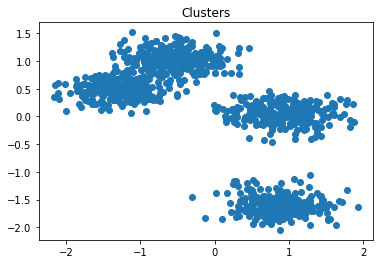

In [ ]:
#data set generator
k=4
n_samples=1000
features=3

# define dataset
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

X, _ = make_blobs(n_samples, centers=k, n_features=features, cluster_std=0.6, random_state=0)

scaler = StandardScaler().fit(X)
X=scaler.transform(X)
#X=scaler.inverse_transform(X)

yhat=np.zeros(n_samples)
    
draw(X,yhat)

### <font color = 'E3A440'>3.3.1. k-means</font>

expliquer l'algorithme

montrer un exemple

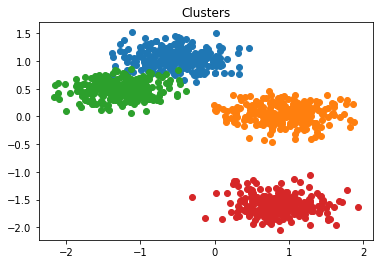

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4).fit(X)

# assign a cluster to each example
yhatkm = model.predict(X)

draw(X,yhatkm)

Notez l'influence du nombre de groupes

### Que ce passe-t-il à chaque itération ?

Iteration : 1


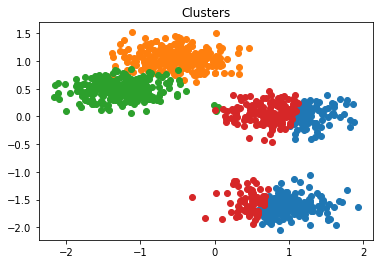

Iteration : 2


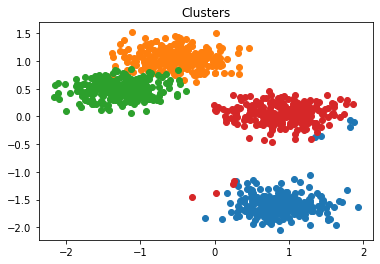

Iteration : 3


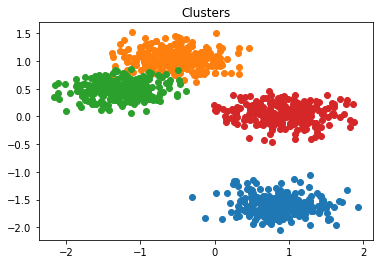

...
...
...

Iteration : 10


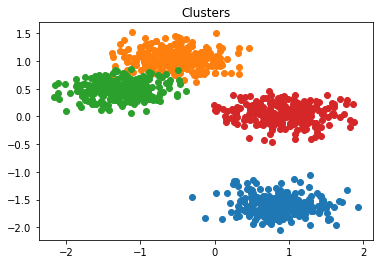

In [ ]:
k=4

for i in range (1,4) :
    print("Iteration :", i)
    model = KMeans(n_clusters=k, max_iter=i, n_init=1, init="random", random_state=1).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

print("...\n...\n...\n")

i=10
print("Iteration :", i)
model = KMeans(n_clusters=k, max_iter=i, n_init=1, init="random", random_state=1).fit(X)
# assign a cluster to each example
yhatkm = model.predict(X)
draw(X,yhatkm)

### Sensibilité à l'initialisation

Random state : 1


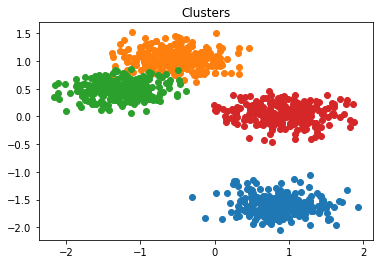

Random state : 2


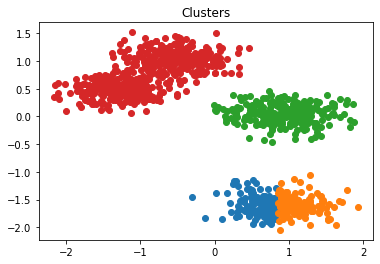

Random state : 3


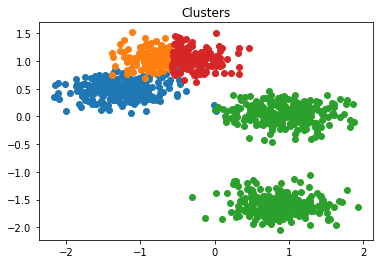

Random state : 4


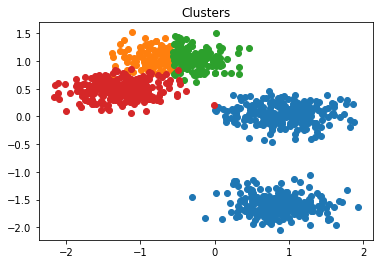

Random state : 5


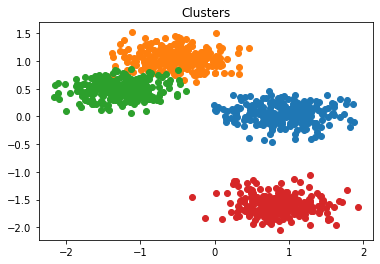

In [ ]:
for rs in range (1,6) :
    print("Random state :", rs)
    model = KMeans(n_clusters=k, n_init=1, init="random", random_state=rs).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

Conclusions :

 - K-means donne un optimum LOCAL.

 - On applique la méthode avec différents points de départ et on garde le meilleur résultat.

### Sensibilité au nombre de groupes

k =  1


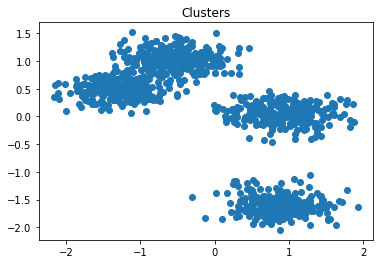

k =  2


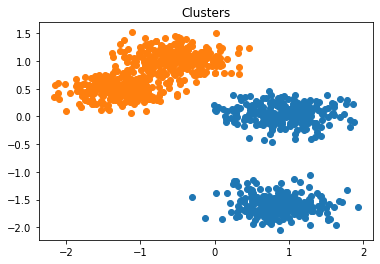

k =  3


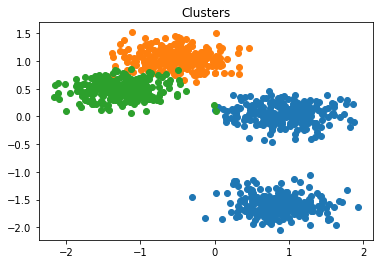

k =  4


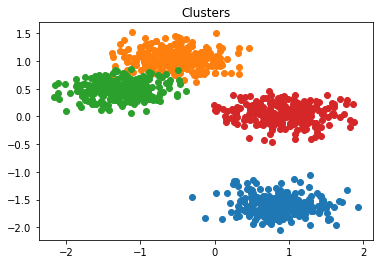

k =  5


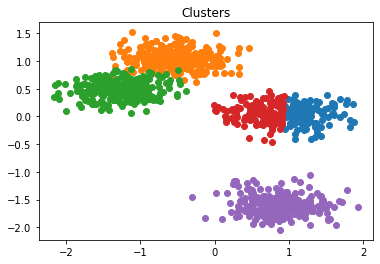

In [ ]:
for m in range (1,6) :
    print("k = ", m)
    model = KMeans(n_clusters=m, max_iter=20, n_init=1, init="random", random_state=1).fit(X)
    # assign a cluster to each example
    yhatkm = model.predict(X)
    draw(X,yhatkm)

Conclusion :

  - Avec K-means il faut connaitre le nombre de groupes que l'on souhaite

### À partir de notre ensemble de textes

[0 0 1 1 0]


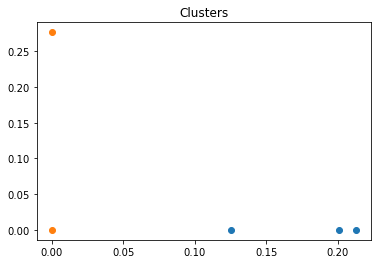

In [ ]:
tfidf_Matrix=tfidf_DTM.toarray()

model = KMeans(n_clusters=2).fit(tfidf_Matrix)

# assign a cluster to each example
yhatkm_tfidf = model.predict(tfidf_Matrix)


print(yhatkm_tfidf)
draw(tfidf_Matrix,yhatkm_tfidf)

Étudier l'influence du nombre de groupes

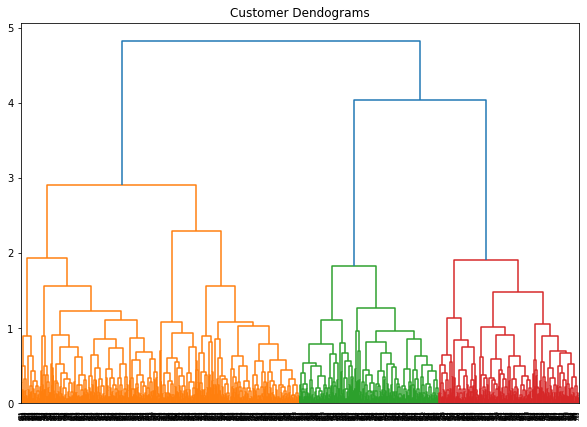

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, metric='euclidean', method='complete'))
plt.show()

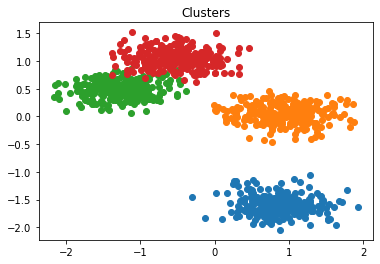

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete').fit(X)
#{“ward”, “complete”, “average”, “single”},

# assign a cluster to each example
yhatac=model.fit_predict(X)

draw(X,yhatac)

### Influence des paramètres de densité

### À partir de notre ensemble de textes

### <font color = 'E3A440'>3.3.4. Évaluation de la segmentation</font>

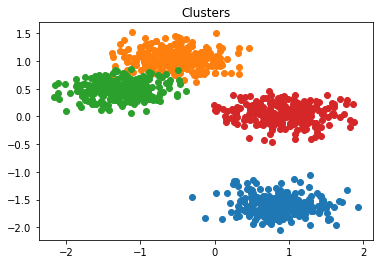

Silhouette= 0.721826710101402
Calinski-Harabasz= 4737.047696788252
Davies Bouldin= 0.4040725616229987


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

model = KMeans(n_clusters=4, max_iter=20, n_init=1, init="random", random_state=1).fit(X)

# assign a cluster to each example
labels = model.predict(X)

draw(X,labels)

print("Silhouette=", silhouette_score(X, labels, metric="euclidean"))
print("Calinski-Harabasz=", calinski_harabasz_score(X, labels))
print("Davies Bouldin=", davies_bouldin_score(X, labels))

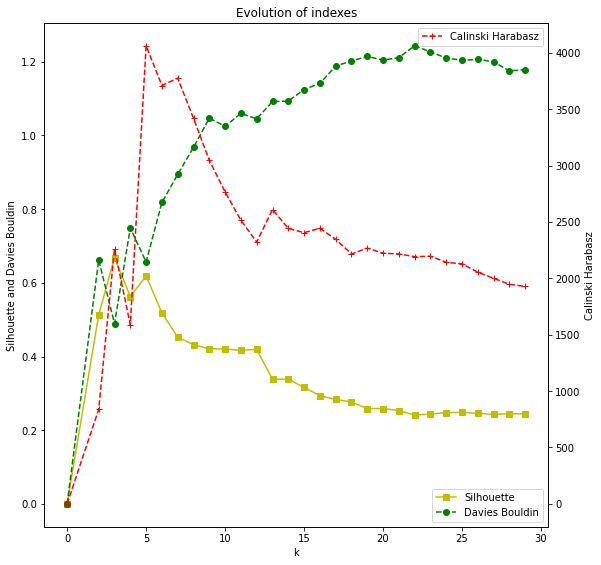

In [ ]:
max=30
Sil=np.zeros(max)
CH=np.zeros(max)
DB=np.zeros(max)
x_axis=np.zeros(max)


for m in range (2,max) :

    model = KMeans(n_clusters=m, max_iter=100, n_init=1, init="random", random_state=3).fit(X)

    # assign a cluster to each example
    labels = model.predict(X)

    Sil[m]=silhouette_score(X, labels, metric="euclidean")
    CH[m]=calinski_harabasz_score(X, labels)
    DB[m]=davies_bouldin_score(X, labels)
    x_axis[m]=m

fig = plt.figure(figsize=(7, 7))
a1 = fig.add_axes([0,0,1,1])
a2 = a1.twinx()
l1 = a1.plot(x_axis,Sil,'ys-') # solid line with yellow colour and square marker
l2 = a1.plot(x_axis,DB,'go--') # dash line with green colour and circle marker
l3 = a2.plot(x_axis,CH,'r+--', label = 'Calinski Harabasz') # dash line with green colour and circle marker
a1.legend(labels = ('Silhouette', 'Davies Bouldin'), loc = 'lower right') # legend placed at lower right
a2.legend(loc=0)
a1.set_xlabel('k')
a1.set_ylabel('Silhouette and Davies Bouldin')
a2.set_ylabel('Calinski Harabasz')
a1.set_title('Evolution of indexes')
plt.show()

### <font color = 'E3A440'>4.3.5. Analyse du contenu des groupes</font>

Cluster 0 : size = 120
Cluster 1 : size = 250
Cluster 2 : size = 250
Cluster 3 : size = 130
Cluster 4 : size = 250


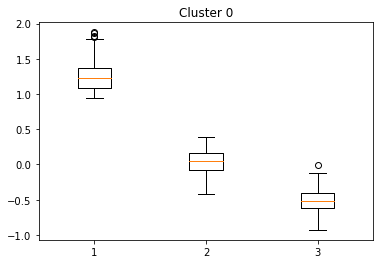

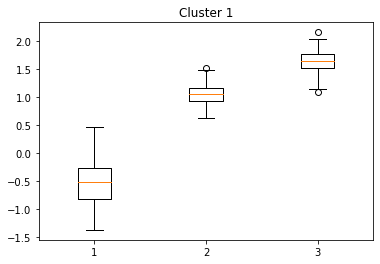

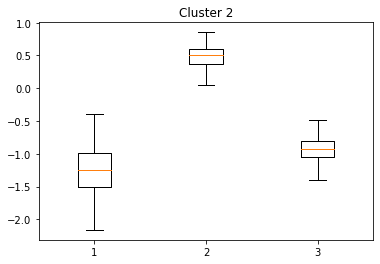

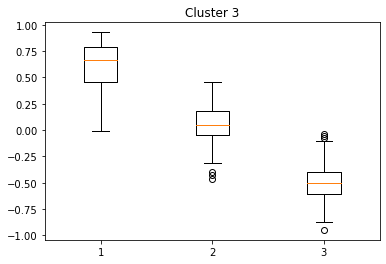

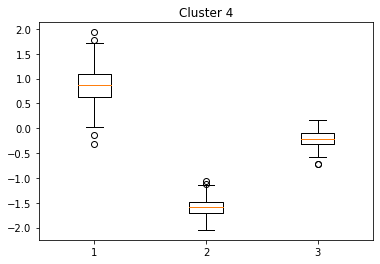

In [ ]:
clusters = unique(yhatkm)

for cluster in clusters:
    C = X[yhatkm[:] == cluster]
    labels=yhatkm[yhatkm[:] == cluster]
    print('Cluster %1.0f : size = %.0f' % (cluster, len(C)))
           
#print('\nCluster centers :')
#print(model.cluster_centers_)    


for cluster in clusters:
    C = X[yhatkm[:] == cluster]
    fig1, ax1 = plt.subplots()
    ax1.set_title('Cluster %1.0f' % (cluster))
    ax1.boxplot(C);

# <font color = 'E3A440'>4. Méthodes supervisées</font>


## <font color = 'E3A440'>4.1. petit réseau de neuronnes</font>

expliquer

donner un exemple :

trouver un texte similaire à un autre

trouver les 3 textes similaires à un autre

on peut répondre à la question :

quels sont les mots importants du/des textes les plus proche



Comparer les deux RN

In [263]:
from sklearn.neural_network import MLPClassifier
tfidf_DTM_norm = Normalizer().transform(tfidf_DTM)

X_train, X_test = tfidf_DTM_norm[:4,:], tfidf_DTM_norm[4:,:]
y_train, y_test = [1,1,2,2],[1]

clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=1)

In [265]:
clf.predict(X_test)

array([1])

# <font color = 'E3A440'>5. Exercice : Analyse des tweets</font>


On reprend le corpus de la session précédente. Ce corpus utilisé a été collecté en 2020 par *trackmyhashtag.com* et contient 150 000 tweets pour les 50 profils les plus suivis de Twitter. Les données sont en format tabulaire dans un fichier CSV. Pour des raisons pédagogiques, cet exercice prévoit l'utilisation d'un échantillon aléatoire de 5 000 tweets.

Dans un premier temps, les données textuelles de 5 000 tweets seront analysées par un module d'analyse de sentiments du module `nltk`. Ensuite, le texte sera prétraité et certaines analyses lexicales seront executées.

Pendant l'exercice, le participant sera invité à remplir les parties manquantes du code qui sont indiquées avec `...` (trois points).

## <font color = 'E3A440'>5.1 Préparation de l'exercice </font>

### <font color = 'E3A440'> a. Importer les données (Rappels) </font>

Le fichier avec les données est archivé dans un `.zip` et contient plus de 150 000 tweets. Pour de raisons pédagogiques, nous importons seulement 5 000 tweets de façon aléatoire. 

In [310]:
#ROOT_DIR='Data_techniques_demystified_webinars/'
ROOT_DIR='Donnees_demystifiees_seance_6/'
DATA_DIR=os.path.join(ROOT_DIR, 'Data')
#import zipfile

from datetime import datetime

#Unzips the dataset and gets the TSV dataset
#with zipfile.ZipFile(os.path.join(DATA_DIR,'4POINT0_Top_50_tweet_profiles.zip'), 'r') as zip_ref:
#    zip_ref.extractall(DATA_DIR)

#df = pd.read_pickle(os.path.join(DATA_DIR,'Top_50_tweet_profiles.pkl')).sample(5000, random_state = 5641).reset_index()
df = pd.read_pickle(os.path.join(DATA_DIR,'4POINT0_sample_scientific_papers.pkl'))

Voici les noms de variables disponibles.

In [5]:
df.columns

Index(['_id', 'Publication', 'PublicationYear', 'Volume', 'Document-type',
       'IDs_autors', 'Authors', 'Affiliations', 'Abstract', 'Keywords'],
      dtype='object')

Voici une observation (une ligne du tableau de données):

In [12]:
df.iloc[0]

_id                                         62fbe989de149ebd6bf4a422
Publication                                             Technovation
PublicationYear                                                 2021
Volume                                                           100
Document-type                                                article
IDs_autors         S016649722030064X-2892d06206214f653c82c56dbae8...
Authors                 Hajime, Sasaki (aff1); Ichiro, Sakata (aff2)
Affiliations       Institute for Future Initiatives, The Universi...
Abstract           \nAs the relationships among technologies beco...
Keywords           Keywords; Technological spin-offs; Internation...
Name: 0, dtype: object

In [51]:
len([ x for row in  df['Keywords'].apply(lambda x: x.split(';')) for x in row])

4846

In [ ]:
set([ x for row in  df['Keywords'].apply(lambda x: x.split(';')) for x in row])

### <font color = 'E3A440'> b. Annotation, nettoyage et vectorisation des tweets (Rappels)</font>

Nous utilisons la fonction écrite précédemment pour nettoyer les unités lexicales de tweets. Pour ce premier test, nous conservons seulement les adjectifs.

Cette opération prendra quelques secondes. 

In [279]:
cleaned_papers = [CleaningText(sent, reduce = 'lemma', list_pos_to_keep = ['ADJ','NOUN','VERB'], Stopwords_to_add=['http','following']) for sent in list(df['Abstract'])]

Dans l'étape de vectorisation, nous retenons les mots qui apparaissent dans au moins 5 documents (min_df = 5).

In [286]:
# Initialisation de l'objet
def identity_tokenizer(text):
    return text
# Transforming the word in frequencies
vectorized = CountVectorizer(lowercase = False, # Convert all characters to lowercase before tokenizing
                             min_df = 10, # Ignore terms that have a document frequency strictly lower than the given threshold 
                             max_df = 1200, # Ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words)
                             stop_words = stopwords.words('english'), # Remove the list of words provided
                             ngram_range = (1, 2), # Get the lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted
                             tokenizer=identity_tokenizer) # Override the string tokenization step while preserving the preprocessing and n-grams generation steps

In [287]:
freq_term_DTM_papers = vectorized.fit_transform([[w for w, pos in sent] for sent in cleaned_papers])
freq_term_DTM_papers

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  % sorted(inconsistent)


<1658x2079 sparse matrix of type '<class 'numpy.int64'>'
	with 84722 stored elements in Compressed Sparse Row format>

In [288]:
# Calculate the tfidf matrix
tfidf = TfidfTransformer(norm='l1')
tfidf_DTM_papers = tfidf.fit_transform(freq_term_DTM_papers)
#print(tfidf_DTM)

tfidf_DF_papers = pd.DataFrame(tfidf_DTM_papers.toarray(), columns =  [k for k, v in sorted(vectorized.vocabulary_.items(), key=lambda item: item[1])] )
print(tfidf_DF_papers)

      ability  able  absence  absorptive  absorptive capacity  abstract  \
0         0.0   0.0      0.0         0.0                  0.0  0.000000   
1         0.0   0.0      0.0         0.0                  0.0  0.000000   
2         0.0   0.0      0.0         0.0                  0.0  0.000000   
3         0.0   0.0      0.0         0.0                  0.0  0.000000   
4         0.0   0.0      0.0         0.0                  0.0  0.000000   
...       ...   ...      ...         ...                  ...       ...   
1653      0.0   0.0      0.0         0.0                  0.0  0.006875   
1654      0.0   0.0      0.0         0.0                  0.0  0.003994   
1655      0.0   0.0      0.0         0.0                  0.0  0.006201   
1656      0.0   0.0      0.0         0.0                  0.0  0.003885   
1657      0.0   0.0      0.0         0.0                  0.0  0.007446   

      abstract aim  abstract article  abstract paper  abstract purpose  ...  \
0              0.0  

## <font color = 'E3A440'>5.2 Question non supervisé </font>

1. Séparer les tweets en groupes homogènes en utilisant un clustering


Évaluer la meilleure partition

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but Normalizer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


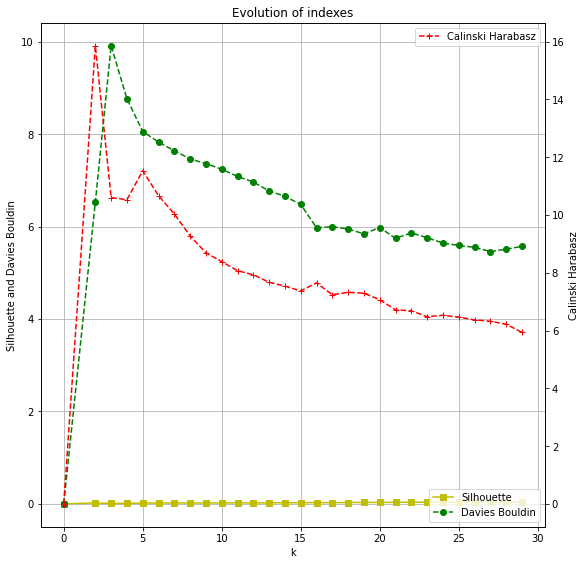

In [266]:
max=30
Sil=np.zeros(max)
CH=np.zeros(max)
DB=np.zeros(max)
x_axis=np.zeros(max)

tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)

for m in range (2,max) :

    model = KMeans(n_clusters=m, max_iter=100, n_init=1, init="k-means++", random_state=3).fit(tfidf_DTM_papers_norm)

    # assign a cluster to each example
    labels = model.predict(tfidf_DTM_papers_norm)

    Sil[m]=silhouette_score(tfidf_DTM_papers_norm, labels, metric="cosine")
    CH[m]=calinski_harabasz_score(tfidf_DTM_papers_norm, labels)
    DB[m]=davies_bouldin_score(tfidf_DTM_papers_norm, labels)
    x_axis[m]=m

fig = plt.figure(figsize=(7, 7))
a1 = fig.add_axes([0,0,1,1])
a2 = a1.twinx()
l1 = a1.plot(x_axis,Sil,'ys-') # solid line with yellow colour and square marker
l2 = a1.plot(x_axis,DB,'go--') # dash line with green colour and circle marker
l3 = a2.plot(x_axis,CH,'r+--', label = 'Calinski Harabasz') # dash line with green colour and circle marker
a1.legend(labels = ('Silhouette', 'Davies Bouldin'), loc = 'lower right') # legend placed at lower right
a2.legend(loc=0)
a1.set_xlabel('k')
a1.set_ylabel('Silhouette and Davies Bouldin')
a2.set_ylabel('Calinski Harabasz')
a1.set_title('Evolution of indexes')
a1.yaxis.grid(True)
a1.xaxis.grid(True)
plt.show()

Ajouter le bon numéro de cluster à génèrer en substituant les trois points `...`

In [289]:
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers.toarray())
model = KMeans(n_clusters = 15, max_iter=20, n_init=1, init="random", random_state=1).fit(tfidf_DTM_papers_norm)
# assign a cluster to each example
labels = model.predict(tfidf_DTM_papers_norm)

print("Silhouette=", silhouette_score(tfidf_DTM_papers_norm, labels, metric="cosine"))
print("Calinski-Harabasz=", calinski_harabasz_score(tfidf_DTM_papers_norm, labels))
print("Davies Bouldin=", davies_bouldin_score(tfidf_DTM_papers_norm, labels))

Silhouette= 0.023961813147549246
Calinski-Harabasz= 6.884044414620763
Davies Bouldin= 6.749185764842506


In [276]:
model.n_clusters

15

In [290]:
Counter(model.labels_)

Counter({9: 67,
         14: 316,
         13: 205,
         6: 75,
         11: 120,
         5: 156,
         0: 178,
         2: 141,
         1: 68,
         3: 69,
         7: 44,
         10: 29,
         8: 20,
         4: 16,
         12: 154})

In [271]:
def plot_data_by_cluster(DTM, cls_kmeans, figsize = (16,10) ):
    ## Reduction of dimension to 2 for visualisation reasons
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import time
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,metric='cosine', learning_rate=10, random_state = 794)
    reduc_dim_results = tsne.fit_transform(DTM)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    ## Create data structure for plotting
    df_reduction = pd.DataFrame()
    df_reduction['y'] =  cls_kmeans.labels_
    df_reduction['1-dim'] = reduc_dim_results[:,0]
    df_reduction['2-dim'] = reduc_dim_results[:,1]

    ## Generate the plot
    import seaborn as sns
    import colorcet as cc
    plt.figure(figsize = figsize)
    sns.scatterplot(data = df_reduction,
                    x="1-dim",
                    y="2-dim",
                    hue="y",
                    palette = sns.color_palette(cc.glasbey, n_colors = cls_kmeans.n_clusters),)

    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1658 samples in 0.004s...
[t-SNE] Computed neighbors for 1658 samples in 0.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1658
[t-SNE] Computed conditional probabilities for sample 1658 / 1658
[t-SNE] Mean sigma: 0.218131
[t-SNE] KL divergence after 50 iterations with early exaggeration: 75.950836
[t-SNE] KL divergence after 1000 iterations: 1.903400
t-SNE done! Time elapsed: 16.33345627784729 seconds


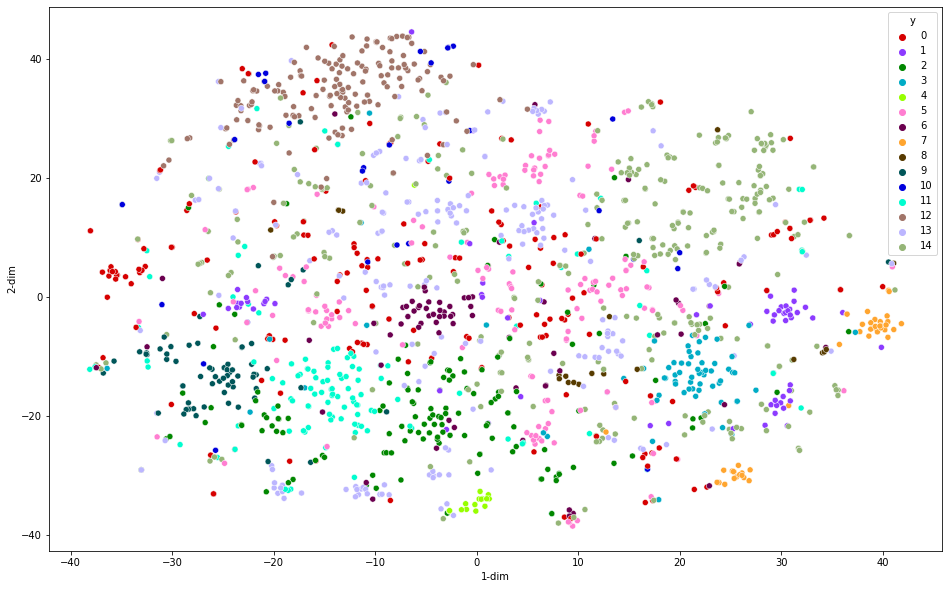

In [291]:
plot_data_by_cluster(tfidf_DTM_papers_norm, model )

In [273]:
def prepare_data_for_WC(DTM, vocabulary_dtm):
    # compute total frequency for each word
    values_words = sum(DTM)
    # values_words = sum(tfidf_matrix)
    # verify type result and prepare data for wordcloud
    if type(values_words) is np.ndarray:
        values_words = [float(value) for value in np.nditer(values_words)]
    elif type(values_words) is scipy.sparse.csr.csr_matrix:
        values_words = [float(value) for value in np.nditer(values_words.todense())]
    else:
        print("Matrix in argument DTM has to be one of these two data classes:  'scipy.sparse.csr.csr_matrix' or 'numpy.ndarray'")
    ##Retrieve the word fromthe vocaboulary and sorting them based on the frequency
    list_mots = sorted(vocabulary_dtm.items(), key= lambda x:x[1])
    list_mots = [word for (word,idx) in  list_mots]
    words = zip(list_mots, values_words)
    words = sorted(words, key= lambda x:x[1], reverse=True)
    ## prepare data structure for wordcloud
    result_for_WC = {}
    #iterating over the tuples lists
    for (key, value) in words:
        result_for_WC[key] = value
    #
    return result_for_WC


def wordcloud_par_cluster(wordcloud, DTM, cls_kmeans, vocab, first_n_words=10, figsize=(18, 16), fontsize=32, plot_wordcloud = True, lst_clust = [], title_in_plot = "Clust_"):

        """
        wordcloud; A WordCloud function.
        DTM; A Docuemnt-Term Matrix
        vocab; It is a vocabulary from skllarn vectorizer
        first_n_words = 10; How many words to print
        figsize = (18, 16); Size of the plot. (this is the argument of this line plt.figure(figsize=figsize))
        fontsize = 32; Size of title font
        lst_clust = []; The list of cluster to plot. If empty, all the clusters are plotted
        title_in_plot = "Clust_"; title to put on top of plot \n
        """
        import numpy
        import scipy
        
        if not lst_clust:
            lst_clust = list(range(cls_kmeans.n_clusters))

        for x in lst_clust:
            DTM_temp = DTM[cls_kmeans.labels_ == x]
            result_for_WC= prepare_data_for_WC(DTM_temp, vocab)
            ###
            if plot_wordcloud == True:
                plot = wordcloud.generate_from_frequencies(result_for_WC)
                plt.figure(figsize=figsize)
                plt.imshow(plot)
                plt.title(title_in_plot + str(x) + '  N. of documents=' + str(DTM_temp.shape[0]),
                        fontsize = fontsize,
                        bbox=dict(facecolor='red', alpha=0.5))
                plt.axis('off')
                plt.show()
            print(f"Most frequent words for cluster {x} of size {str(DTM_temp.shape[0])} docs: ", list(result_for_WC)[0:first_n_words])

In [292]:
from wordcloud import WordCloud
wordcloud_par_cluster(wordcloud = WordCloud(), # WordCloud function. 
                      DTM = tfidf_DTM_papers_norm,# Document-Term Matrix 
                      cls_kmeans = model, # Insert the result of a kmeans clustering
                      vocab = vectorized.vocabulary_, # a vocabulary from scikitlearn vectorizer
                      first_n_words=10,#  It indicates how many words to print
                      figsize=(12, 10),
                      fontsize=32,
                      plot_wordcloud = False, # Switch to True if you want to plot wordclouds
                      lst_clust = [], # Insert a list of integer to get info about a selected number of cluster. It shows info of all the clustrs if empty list
                      title_in_plot = "Clust_")

Most frequent words for cluster 0 of size 178 docs:  ['strategy', 'company', 'international', 'global', 'mnes', 'firm', 'paper', 'ha', 'strategic', 'industry']
Most frequent words for cluster 1 of size 68 docs:  ['supply', 'chain', 'supplier', 'supply chain', 'project', 'management', 'relationship', 'customer', 'project management', 'implementation']
Most frequent words for cluster 2 of size 141 docs:  ['firm', 'capability', 'market', 'performance', 'product', 'effect', 'resource', 'npd', 'new', 'dynamic']
Most frequent words for cluster 3 of size 69 docs:  ['service', 'customer', 'value', 'provider', 'service provider', 'system', 'complex', 'servitization', 'product', 'process']
Most frequent words for cluster 4 of size 16 docs:  ['board', 'ceo', 'director', 'executive', 'structure', 'governance', 'woman', 'firm', 'performance', 'experience']
Most frequent words for cluster 5 of size 156 docs:  ['marketing', 'research', 'knowledge', 'management', 'business', 'model', 'business model',

## <font color = 'E3A440'>5.3 Question supervisé </font>

Classifier abstract with previous clustering

In [293]:
from sklearn.model_selection import train_test_split
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)
X_train, X_test, y_train, y_test = train_test_split(tfidf_DTM_papers_norm, model.labels_, test_size = 0.2,  random_state=1)

In [294]:
print(X_train.shape)
print(len(y_train))

(1326, 2079)
1326


In [295]:
print(X_test.shape)
print(len(y_test))

(332, 2079)
332


In [296]:
cls = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [297]:
y_pred = cls.predict(X_test)

In [298]:
cls.score(X_test, y_test)

0.8042168674698795

In [299]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.7607180993807681

Classifier abstract with innovation

In [304]:
innov_labels = df.Abstract.apply(lambda x : 1 if re.search('innov\w', x) else 0 )
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)
X_train, X_test, y_train, y_test = train_test_split(tfidf_DTM_papers_norm, innov_labels, test_size = 0.2,  random_state=1)
cls = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))
print(cls.score(X_test, y_test))

0.7255984229794424
0.8734939759036144


Classifier abstract with publication

In [306]:
publi_labels = list(df.Publication)
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)
X_train, X_test, y_train, y_test = train_test_split(tfidf_DTM_papers_norm, publi_labels, test_size = 0.2,  random_state=1)
cls = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))
print(cls.score(X_test, y_test))

0.5935454289173798
0.7409638554216867


In [307]:
year_labels = list(df.PublicationYear)
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
tfidf_DTM_papers_norm = Normalizer().transform(tfidf_DTM_papers)
X_train, X_test, y_train, y_test = train_test_split(tfidf_DTM_papers_norm, year_labels, test_size = 0.2,  random_state=1)
cls = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred))
print(cls.score(X_test, y_test))

0.20140779423675373
0.26506024096385544


## <font color = 'E3A440'> 2.3 NOTES PERSONNELLES: </font>

-----

-----